# colab settings:

In [0]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download to Colab from Google Drive:
# https://drive.google.com/open?id=YOUR_FILE_ID
download = drive.CreateFile({'id': '10AWC5jfxqdDXode3_1vkDKZpWVeAROV4'}) # 'id': 'YOUR_FILE_ID'
download.GetContentFile('dataset.tar')

In [0]:
# upload to Google Drive from Colab:
upload = drive.CreateFile({'title': 'DRIVE.txt'})
upload.SetContentFile('FILE_ON_COLAB.txt')
upload.Upload()

In [1]:
!ls

adc.json  dataset.tar  INRIAPerson  sample_data


In [0]:
!ls "/content/drive/My Drive/Colab Notebooks/Project31/"

CNN_HOG.ipynb  LinearSVC_HOG.npy	       model_wieghts_batch4_epochs16.h5
dataset.tar    LinkReview.docx		       README.md
INRIAPerson    model_keras_batch4_epochs16.h5  SVM_HOG.ipynb


In [0]:
!tar -xvf dataset.tar

# Train CNN+HOG (layer) classifier from keras on INRIA dataset

Tutorial: https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9

Code on git: https://github.com/risenW/medium_tutorial_notebooks/blob/master/dogs-vs-cats-keras-implementation.ipynb


In [0]:
#from skimage.feature import hog
#from sklearn.externals import joblib
#from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import classification_report
from skimage.io import imread
from skimage import data, color

import numpy as np
import os



In [0]:
# define parameters of HOG feature extraction
# change them if necessary to orientations = 8, pixels per cell = (16,16), cells per block to (1,1) for weaker HOG
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = .3
# 9 * 4(16x16 / 8x8) = 36 
# 36 * 105 (7 * 15 - pos of 16x16) 3780

# define size for train and test data
PERSON_WIDTH = 64
PERSON_HEIGHT = 128
leftop_train = [16, 16]
rightbottom_train = [16 + PERSON_WIDTH, 16 + PERSON_HEIGHT]
leftop_test = [3, 3]
rightbottom_test = [3 + PERSON_WIDTH, 3 + PERSON_HEIGHT]

In [0]:
# COLAB
# define path to images:

#train_pos_img_dir = '/content/drive/My Drive/Colab Notebooks/Project31/INRIAPerson/train_64x128_H96/pos/'
#train_neg_img_dir = '/content/drive/My Drive/Colab Notebooks/Project31/INRIAPerson/train_64x128_H96/neg/'
#test_pos_img_dir = '/content/drive/My Drive/Colab Notebooks/Project31/INRIAPerson/test_64x128_H96/pos/'
#test_neg_img_dir = '/content/drive/My Drive/Colab Notebooks/Project31/INRIAPerson/test_64x128_H96/neg/'



In [0]:
# JUPYTER or COLAB (dataset.tar)
# define path to images:

train_pos_img_dir = 'INRIAPerson/train_64x128_H96/pos/'
train_neg_img_dir = 'INRIAPerson/train_64x128_H96/neg/'
test_pos_img_dir = 'INRIAPerson/test_64x128_H96/pos/'
test_neg_img_dir = 'INRIAPerson/test_64x128_H96/neg/'

In [5]:
# read the image files:
train_pos_images = os.listdir(train_pos_img_dir)
train_neg_images = os.listdir(train_neg_img_dir)
test_pos_images = os.listdir(test_pos_img_dir)
test_neg_images = os.listdir(test_neg_img_dir)

trainData = []
testData = []
trainLabels = []
testLabels = []

from skimage.feature import hog

# loading train data
print('loading ' + str(len(train_pos_images)) + ' positive images [Train]')
for train_pos_image in train_pos_images:
    pos_img = data.imread(train_pos_img_dir + train_pos_image, as_gray=False)
    pos_roi = pos_img[leftop_train[1]:rightbottom_train[1], leftop_train[0]:rightbottom_train[0]]
    
    fd, img = hog(color.rgb2gray(pos_roi), orientations, pixels_per_cell, cells_per_block, block_norm='L2', visualize=True)
    rgb_hog = np.dstack((color.rgba2rgb(pos_roi), img))
    
    trainData.append(rgb_hog)  
    trainLabels.append(1)
                       

print('loading ' + str(len(train_neg_images)) + ' negative images [Train]')
for train_neg_image in train_neg_images:
    neg_img = data.imread(train_neg_img_dir + train_neg_image, as_gray=False)
    neg_roi = neg_img[leftop_train[1]:rightbottom_train[1], leftop_train[0]:rightbottom_train[0]]
    
    fd, img = hog(color.rgb2gray(neg_roi), orientations, pixels_per_cell, cells_per_block, block_norm='L2', visualize=True)
    rgb_hog = np.dstack((neg_roi, img))
    
    trainData.append(rgb_hog)
    trainLabels.append(0)   

# loading test data    
print('loading ' + str(len(test_pos_images)) + ' positive images [Test]')
for test_pos_image in test_pos_images:
    pos_img = data.imread(test_pos_img_dir + test_pos_image, as_gray=False)
    pos_roi = pos_img[leftop_test[1]:rightbottom_test[1], leftop_test[0]:rightbottom_test[0]]
    
    fd, img = hog(color.rgb2gray(pos_roi), orientations, pixels_per_cell, cells_per_block, block_norm='L2', visualize=True)
    rgb_hog = np.dstack((color.rgba2rgb(pos_roi), img))
    
    testData.append(rgb_hog) 
    testLabels.append(1)
    
print('loading ' + str(len(test_neg_images)) + ' negative images [Test]')
for test_neg_image in test_neg_images:
    neg_img = data.imread(test_neg_img_dir + test_neg_image, as_gray=False)
    neg_roi = neg_img[leftop_test[1]:rightbottom_test[1], leftop_test[0]:rightbottom_test[0]]
    
    fd, img = hog(color.rgb2gray(neg_roi), orientations, pixels_per_cell, cells_per_block, block_norm='L2', visualize=True)
    rgb_hog = np.dstack((neg_roi, img))
    
    testData.append(rgb_hog)
    testLabels.append(0)  

loading 2416 positive images [Train]
loading 1218 negative images [Train]
loading 1132 positive images [Test]
loading 453 negative images [Test]


In [6]:
print ('Train data size: {}'.format(np.asarray(trainData).shape))
print ('Test data size: {}'.format(np.asarray(testData).shape))

Train data size: (3634, 128, 64, 4)
Test data size: (1585, 128, 64, 4)


In [0]:
X_train = np.array(trainData)
X_val = np.array(testData)
y_train = np.array(trainLabels)
y_val = np.array(testLabels)

In [0]:
# clear memory
import gc 
del trainData
del testData
del trainLabels
del testLabels
gc.collect()

# get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

# batch size should be a factor of 2 ***4,8,16,32,64...***
# 4 for faster training
batch_size = 4


In [0]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

# for faster computing on my own laptop (doesn't work)
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(128, 64, 4)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))  #Dropout for regularization
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

In [11]:
# model description
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 62, 32)       1184      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 29, 16)        4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 14, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6720)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6720)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               3441152   
__________

In [0]:
# RMSprop optimizer with a learning rate of 0.0001
# binary_crossentropy loss because its a binary classification
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [0]:
# create the augmentation configuration
# this helps prevent overfitting
'''
train_datagen = ImageDataGenerator(rescale=1./255,   # scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

                        
val_datagen = ImageDataGenerator(rescale=1./255)  # do not augment validation data, only perform rescale
'''
val_datagen = ImageDataGenerator()
train_datagen = ImageDataGenerator()

In [0]:
# create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [15]:
# the training part
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=16,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/16
908/908 [==============================] - 8s 9ms/step - loss: 5.3420 - acc: 0.6644 - val_loss: 4.5593 - val_acc: 0.7140
Epoch 2/16
908/908 [==============================] - 7s 7ms/step - loss: 5.3549 - acc: 0.6641 - val_loss: 4.5578 - val_acc: 0.7141
Epoch 3/16
908/908 [==============================] - 6s 7ms/step - loss: 5.3330 - acc: 0.6655 - val_loss: 4.5578 - val_acc: 0.7141
Epoch 4/16
908/908 [==============================] - 6s 7ms/step - loss: 5.3283 - acc: 0.6657 - val_loss: 4.5679 - val_acc: 0.7135
Epoch 5/16
908/908 [==============================] - 7s 7ms/step - loss: 5.3630 - acc: 0.6635 - val_loss: 4.5276 - val_acc: 0.7160
Epoch 6/16
908/908 [==============================] - 6s 7ms/step - loss: 5.3233 - acc: 0.6660 - val_loss: 4.5276 - val_acc: 0.7160
Epoch 7/16
908/908 [==============================] - 6s 7ms/step - loss: 5.3543 - acc: 0.6641 - val_loss: 4.5780 - val_acc: 0.7128
Epoch 8/16
908/908 [========

In [0]:
# save the model
model.save_weights('model_wieghts_batch4_epochs16_hog.h5')
model.save('model_keras_batch4_epochs16_hog.h5')

In [0]:
upload = drive.CreateFile({'title': 'model_keras_batch4_epochs16_hog.h5'})
upload.SetContentFile('model_keras_batch4_epochs16_hog.h5')
upload.Upload()

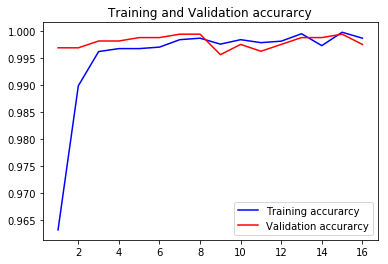

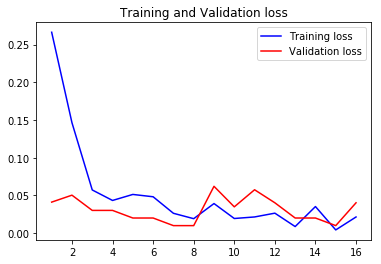

In [0]:
# plot the train and val curve
# get the details form the history object
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
# train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


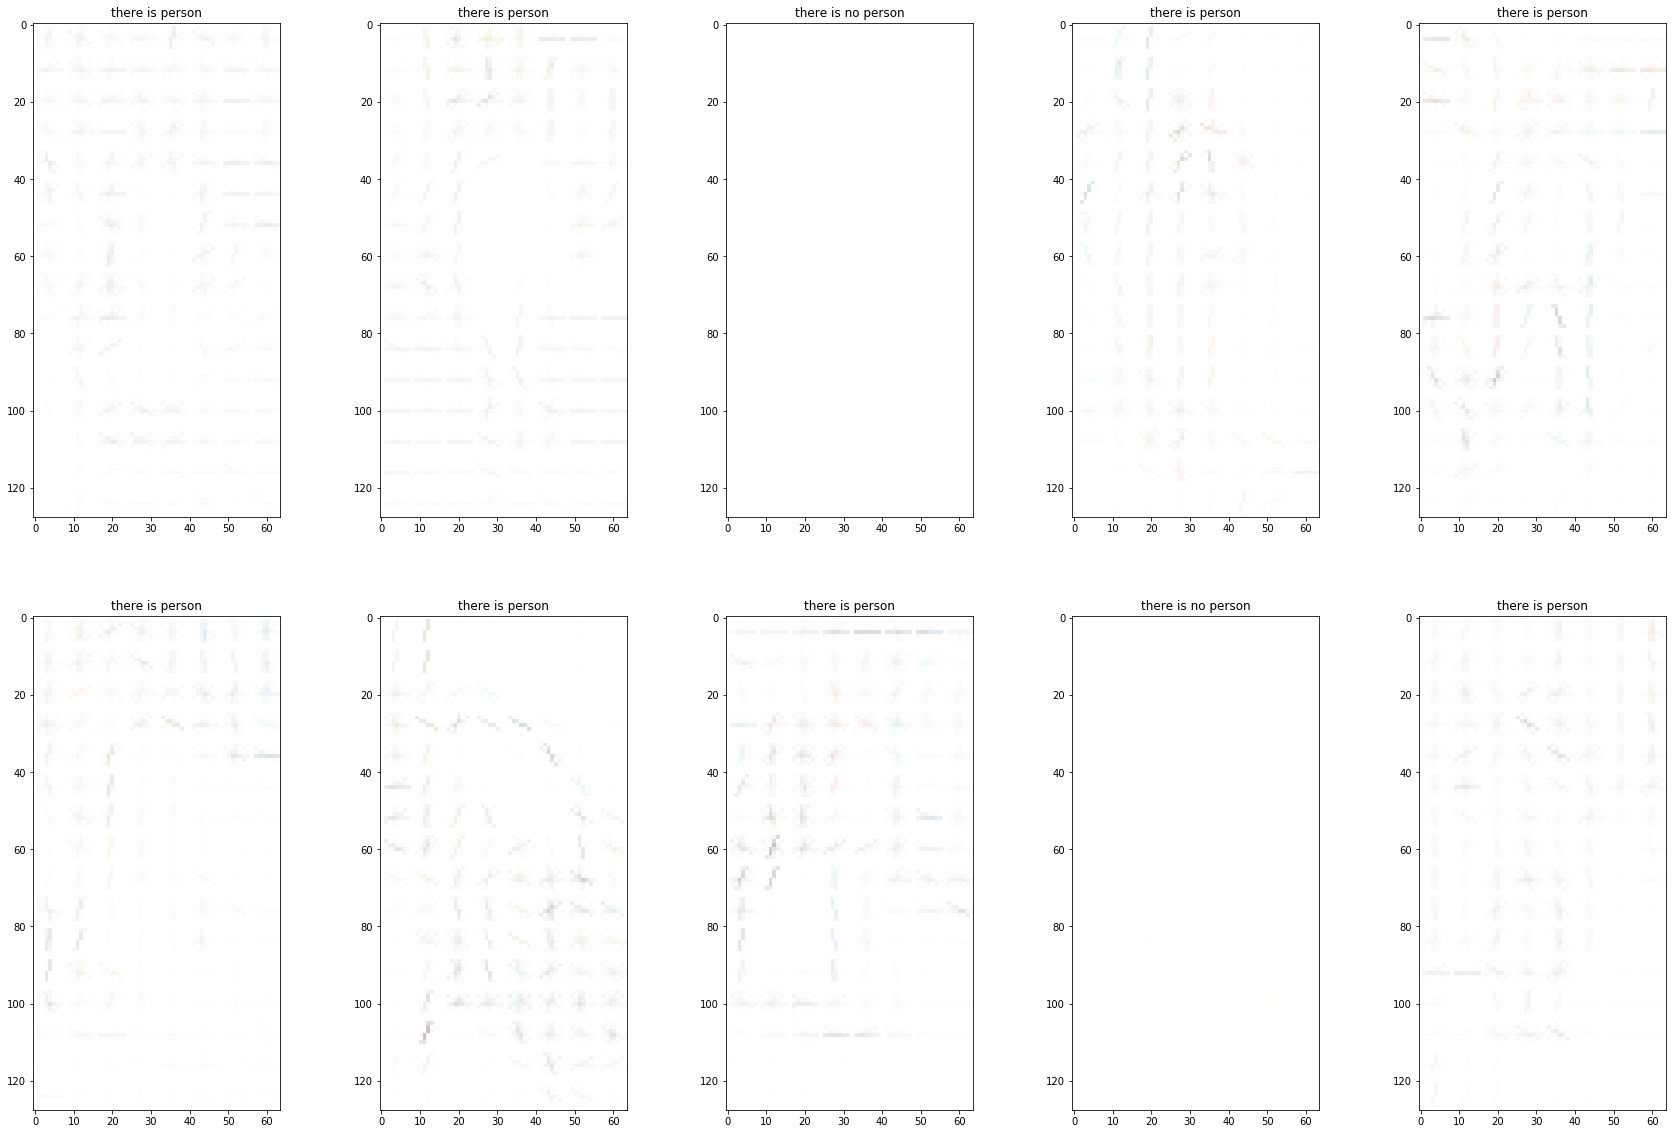

In [0]:
#test_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator() 

#from keras.models import load_model
#loaded_model = load_model('model_keras_batch4_epochs16.h5')
#loaded_model.load_weights("model_wieghts_batch4_epochs16.h5")

i = 0
columns = 5
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(X_val, batch_size=1): # X_val instead of X_test
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('there is person')
    else:
        text_labels.append('there is no person')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title(text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()